In [4]:
import os
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches as mpatches

import sys
sys.path.append('../../')
from rllte.evaluation.visualization import _annotate_and_decorate_axis, plot_interval_estimates
from rllte.evaluation import Performance

In [2]:
root = '/Users/yuanmingqi/Downloads/nips2024_data/q3/01/'
for folder in os.listdir(root):
    if folder == '.DS_Store':
        continue
    if len(os.listdir(os.path.join(root, folder))) != 1:
        print(folder, os.listdir(os.path.join(root, folder)))

root = '/Users/yuanmingqi/Downloads/nips2024_data/q3/05/'
for folder in os.listdir(root):
    if folder == '.DS_Store':
        continue
    if len(os.listdir(os.path.join(root, folder))) != 1:
        print(folder, os.listdir(os.path.join(root, folder)))

root = '/Users/yuanmingqi/Downloads/nips2024_data/q3/10/'
for folder in os.listdir(root):
    if folder == '.DS_Store':
        continue
    if len(os.listdir(os.path.join(root, folder))) != 1:
        print(folder, os.listdir(os.path.join(root, folder)))

In [3]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
root = "/Users/yuanmingqi/Downloads/nips2024_data/q3/01/"
num_points = 10
all_data = {algo: [] for algo in algos}
for algo in algos:
    for dir in os.listdir(root):
        if algo.lower() in dir:
            file = f"{root}/{dir}/"
            file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
            data = pd.read_csv(file)#['episode_reward']
            if data['step'].values[-1] != 9999360:
                print(file)

root = "/Users/yuanmingqi/Downloads/nips2024_data/q3/05/"
num_points = 10
all_data = {algo: [] for algo in algos}
for algo in algos:
    for dir in os.listdir(root):
        if algo.lower() in dir:
            file = f"{root}/{dir}/"
            file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
            data = pd.read_csv(file)#['episode_reward']
            if data['step'].values[-1] != 9999360:
                print(file)

root = "/Users/yuanmingqi/Downloads/nips2024_data/q3/10/"
num_points = 10
all_data = {algo: [] for algo in algos}
for algo in algos:
    for dir in os.listdir(root):
        if algo.lower() in dir:
            file = f"{root}/{dir}/"
            file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
            data = pd.read_csv(file)#['episode_reward']
            if data['step'].values[-1] != 9999360:
                print(file)

/Users/yuanmingqi/Downloads/nips2024_data/q3/10//PPO_SuperMarioBros-1-1-v3_ngu_obsRMS:True_rewNorm:rms_updateProp:1.0_rff:False_weightInit:orthogonal_s3/2024-02-26-10-30-31/train.log


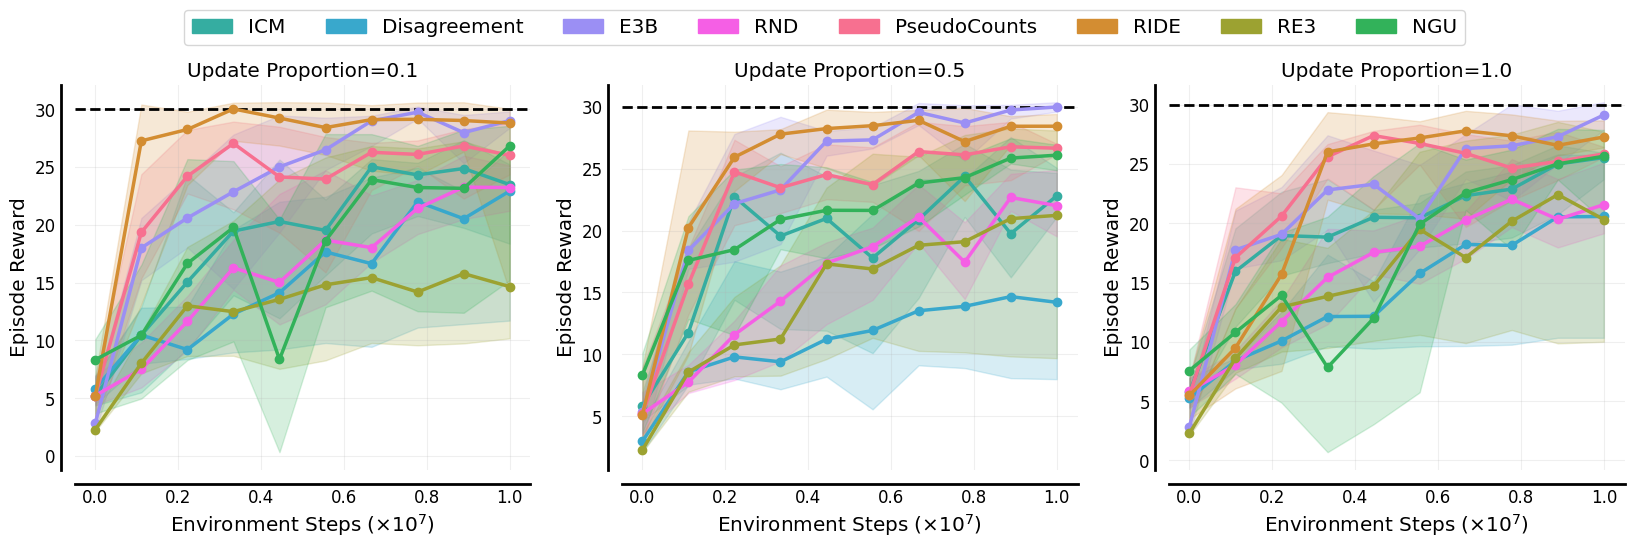

In [5]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
titles = ['Update Proportion=0.1', 'Update Proportion=0.5', 'Update Proportion=1.0']
# colors = sns.color_palette("husl", len(algos))
colors = sns.husl_palette(len(algos), h=.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for subplot_idx, candidate in enumerate(['01', '05', '10']):
    root = f"C:/Users/BIRL/Downloads/nips2024_data/q3/{candidate}/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    ax = axes[subplot_idx]

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        all_data[algo] = np.expand_dims(all_data[algo], axis=1)

    sampling_dict = dict()
    for algo in algos:
        sampling_dict[algo] = [[], [], []]
        for frame in range(num_points):
            perf = Performance(all_data[algo][:, :, frame], get_ci=True, reps=2000)
            value, CIs = perf.aggregate_iqm()
            sampling_dict[algo][0].append(value)
            sampling_dict[algo][1].append(CIs[0]) # lower bound
            sampling_dict[algo][2].append(CIs[1]) # upper bound

        sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
        sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
        sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

    x = np.linspace(0, 1, num_points)
    ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
    for algo, color in zip(algos, colors):
        mean, ci_high, ci_low = sampling_dict[algo]
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=color, label=algo)
        ax.fill_between(x, ci_high, ci_low, alpha=0.2, color=color)

    ax.set_title(titles[subplot_idx], fontsize="x-large")
    ax = _annotate_and_decorate_axis(ax, 
                                    ticklabelsize="large",
                                    xlabel=r"Environment Steps ($\times 10^7$)", 
                                    ylabel="Episode Reward",
                                    xticklabels=np.linspace(0, 1, num_points),
                                    )
fig.legend(fake_patches, algos, loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 1.05))
fig.savefig('figure_rq3_curves.pdf', bbox_inches='tight', dpi=300)

### Bar

/home/roger/Desktop/rllte/all_mario_runs//obs. norm./PPO_SuperMarioBros-1-1-v3_re3_obsRMS:True_rewNorm:rms_updateProp:1.0_rff:False_s1//2024-02-13-07-43-46/train.log


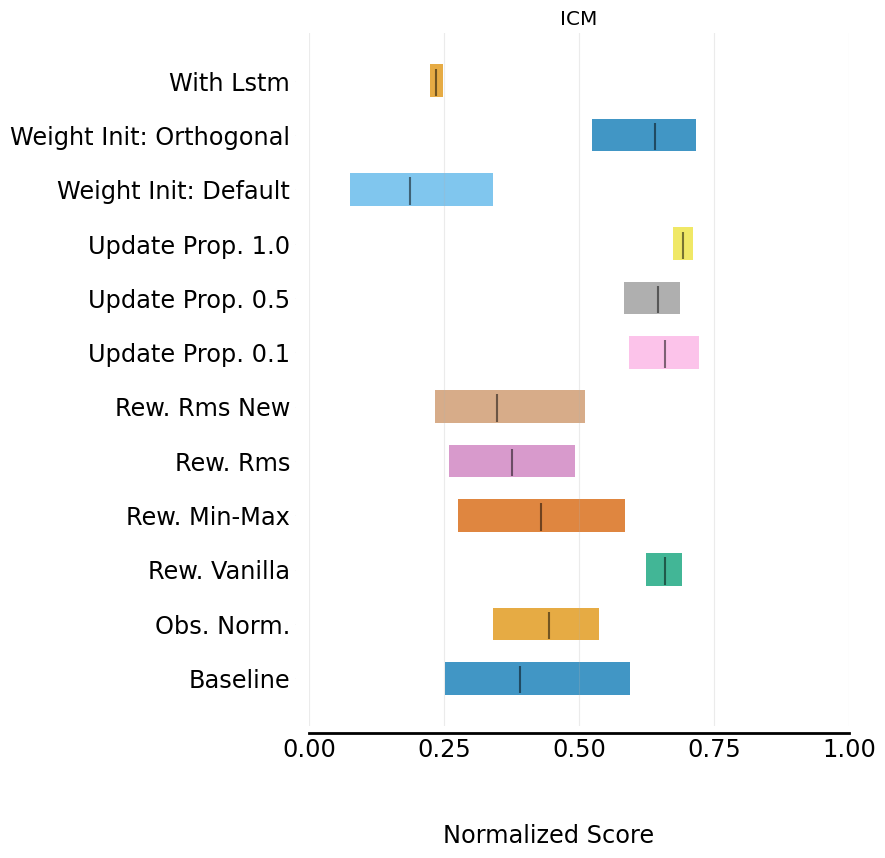

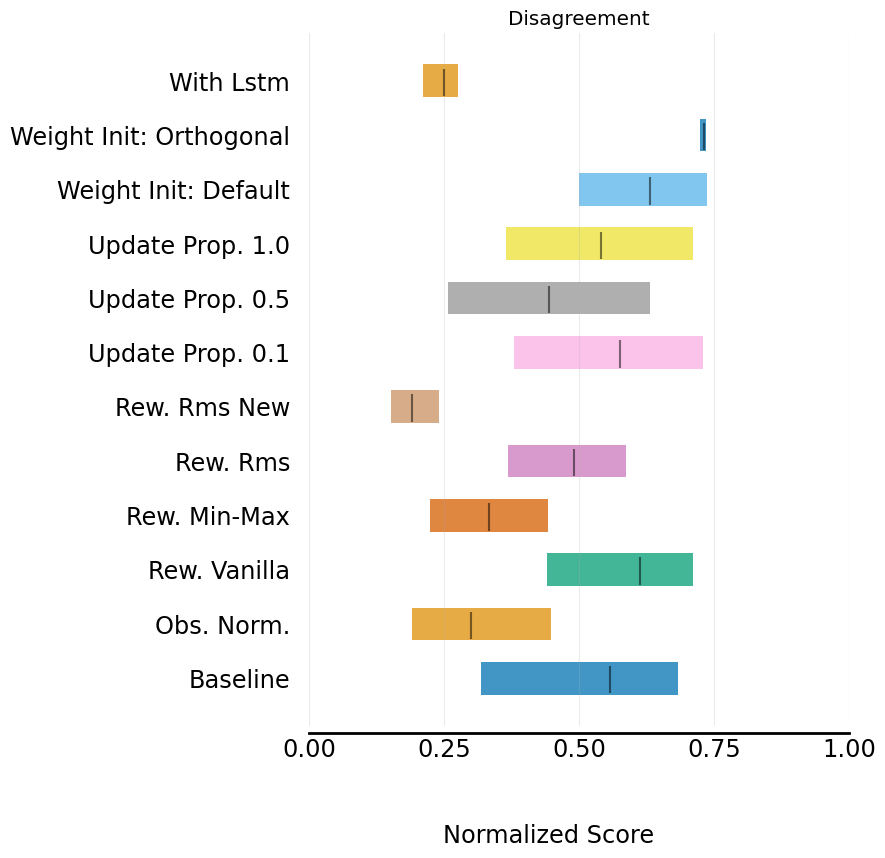

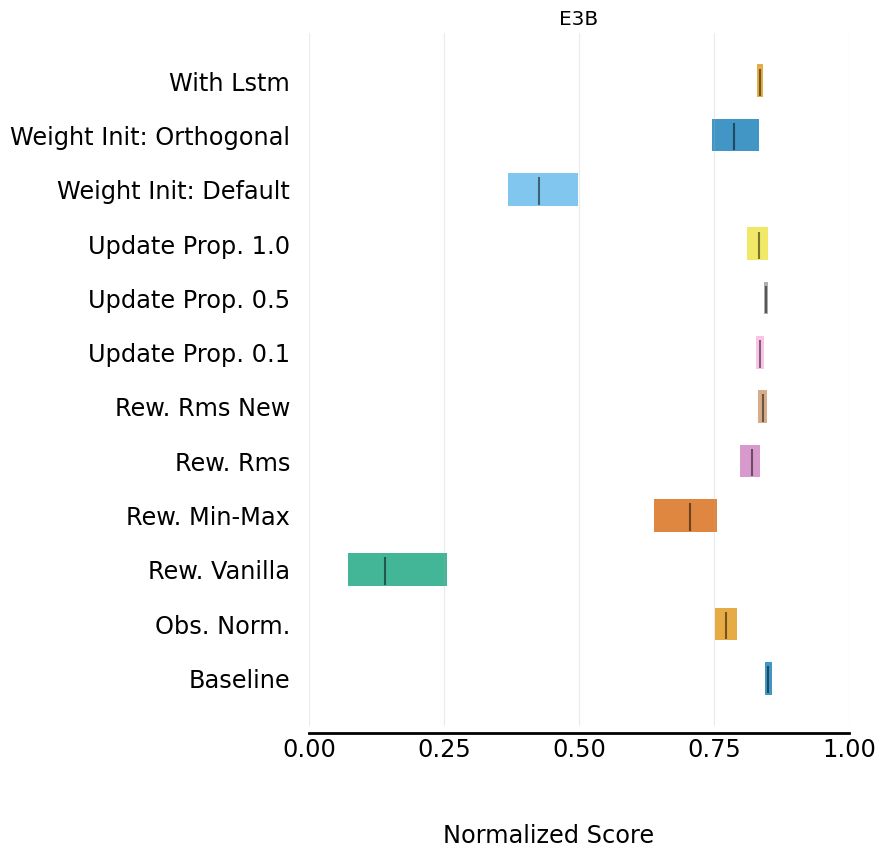

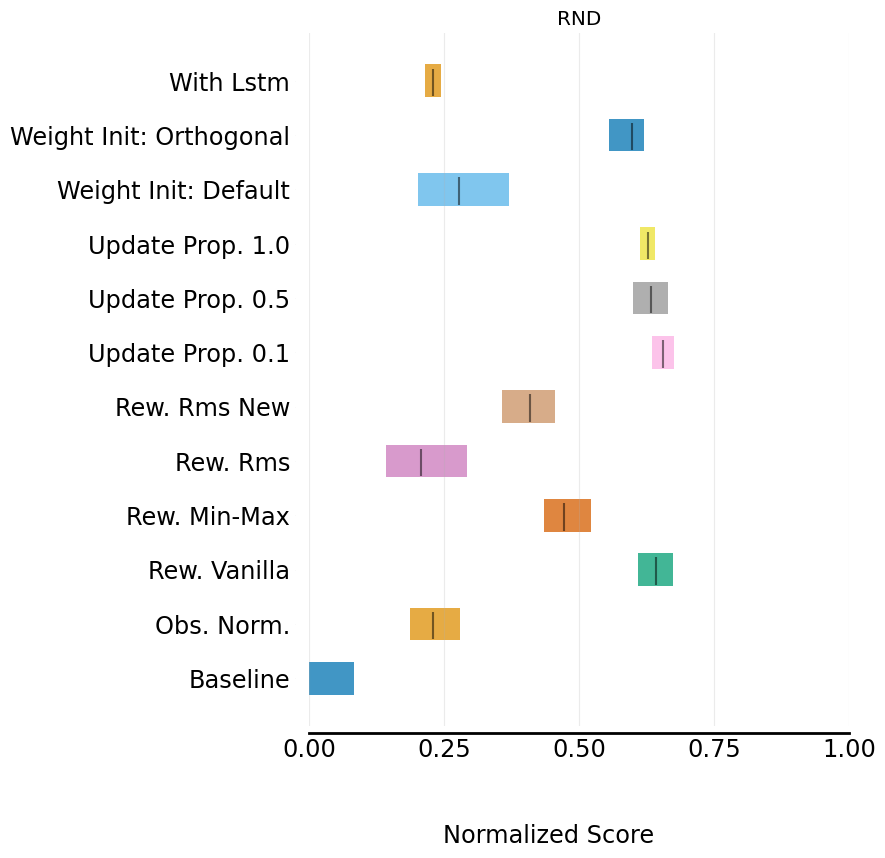

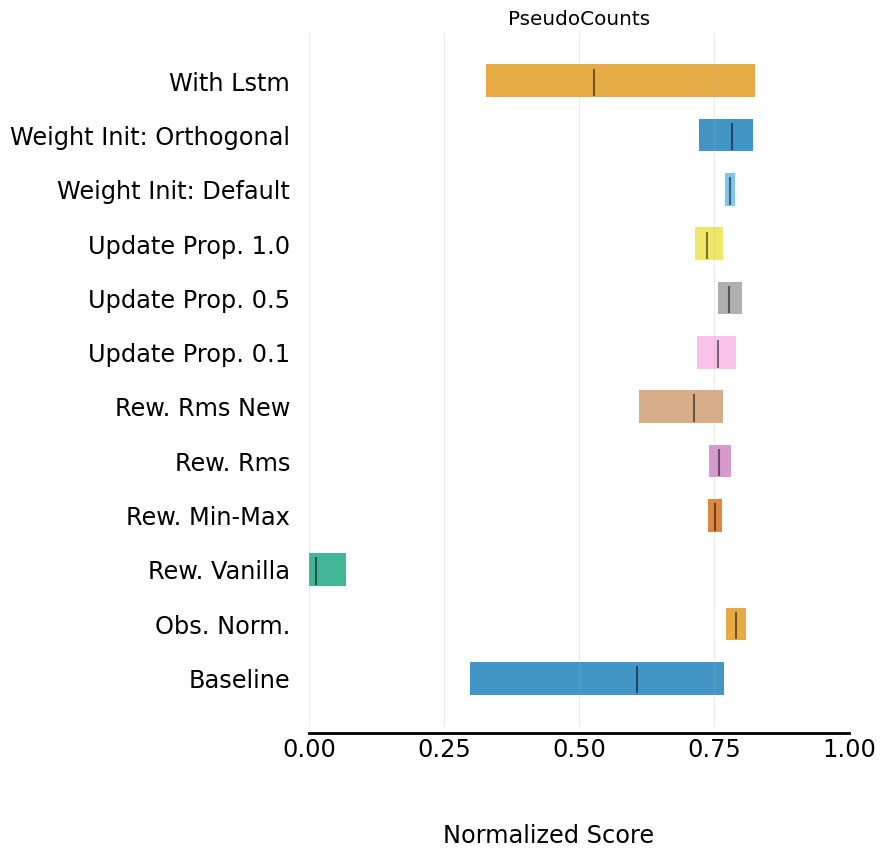

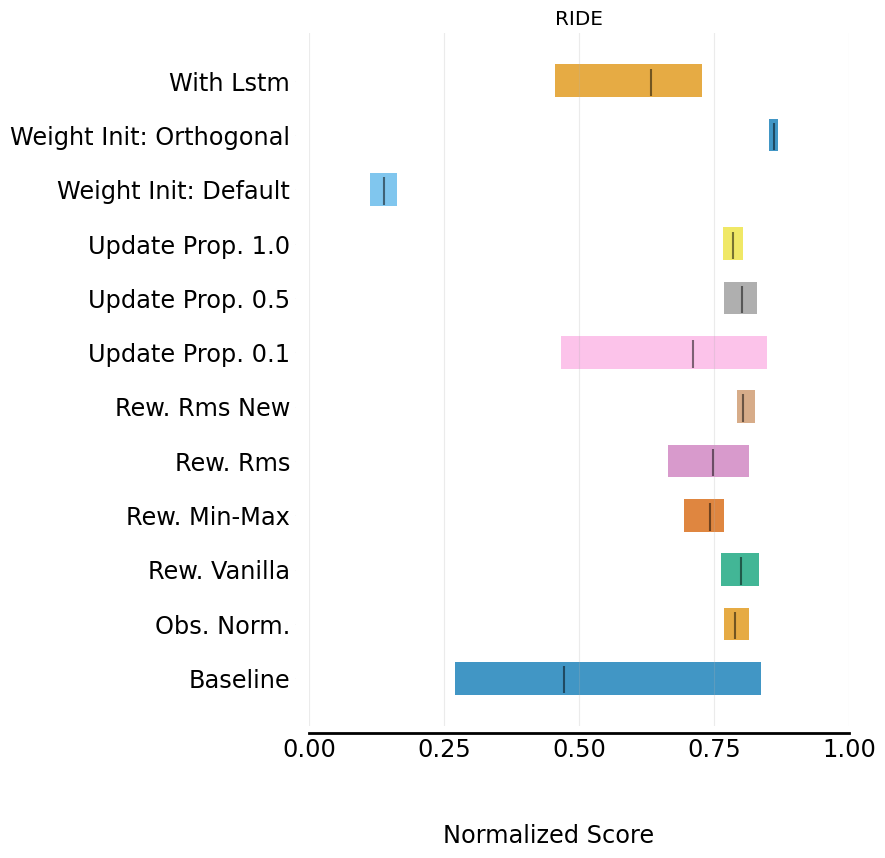

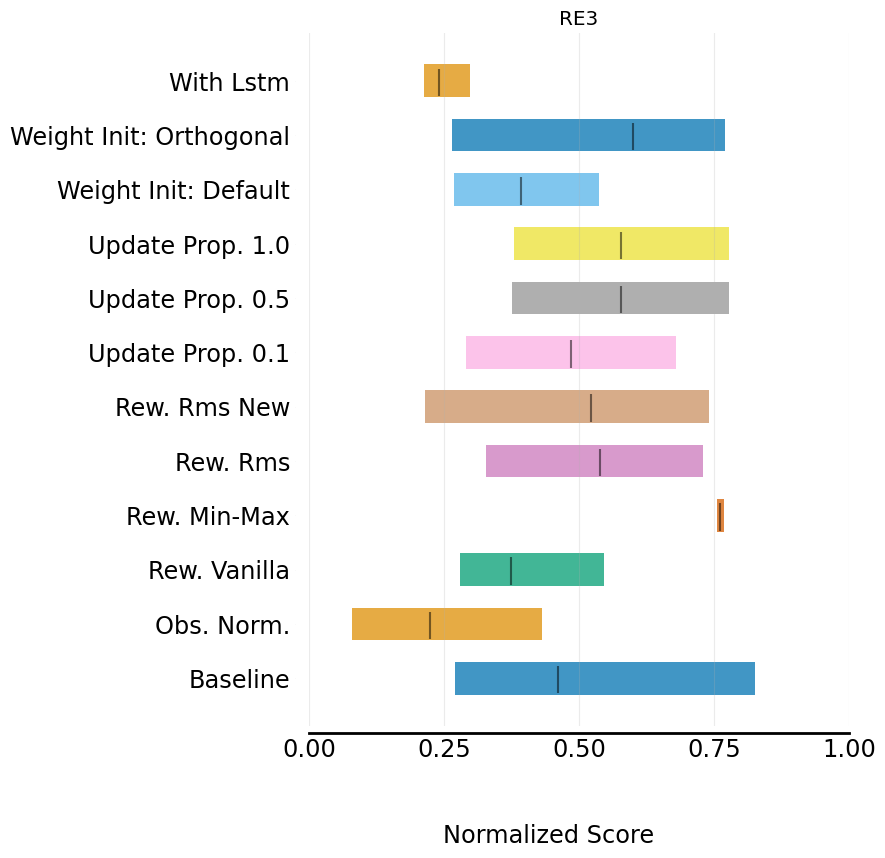

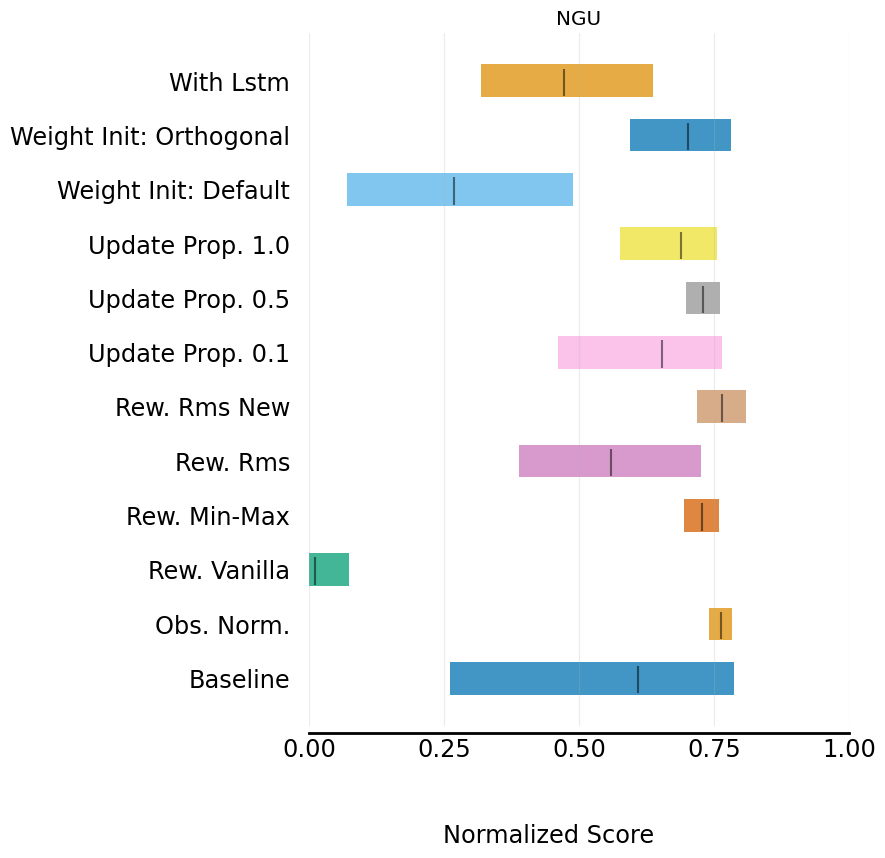

In [10]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
for algo in algos:
    num_last_episodes = 100
    max_episode_return = 35
    root = "/home/roger/Desktop/rllte/all_mario_runs/"
    types = ['Baseline', 'Obs. Norm.', 'Rew. Vanilla', 'Rew. Min-Max', 'Rew. Rms', 'Rew. Rms New', 'Update Prop. 0.1', 'Update Prop. 0.5', 'Update Prop. 1.0', 'Weight Init: Default', 'Weight Init: Orthogonal', 'With Lstm']
    colors = sns.color_palette("husl", len(types))
    all_data = {type: [] for type in types}

    for type in types:
        for dir in os.listdir(root + type.lower()):
            if algo.lower() in dir:
                file = f"{root}/{type.lower()}/{dir}/"
                file = file + '/' + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                try:
                    data = pd.read_csv(file)['episode_reward']
                except:
                    print(file)
                    continue
                data = data[-num_last_episodes:]
                all_data[type].append(data)

        all_data[type] = np.array(all_data[type]).mean(axis=1, keepdims=True) / max_episode_return

    aggregate_performance_dict = {
        "MEAN": {},
        #"MEDIAN": {},
        #"IQM": {},
        #"OG": {}
    }
    for type in all_data.keys():
        perf = Performance(scores=all_data[type], get_ci=True)
        aggregate_performance_dict['MEAN'][type] = perf.aggregate_mean()
        #aggregate_performance_dict['MEDIAN'][type] = perf.aggregate_median()
        #aggregate_performance_dict['IQM'][type] = perf.aggregate_iqm()
        #aggregate_performance_dict['OG'][type] = perf.aggregate_og()

    fig, ax = plot_interval_estimates(aggregate_performance_dict, 
                                    metric_names=['MEAN'],# 'IQM'], #'MEDIAN', 'IQM', 'OG'], 
                                    algorithms=types, 
                                    xlabel="Normalized Score",
                                    subfigure_width=6,
                                    xlabel_y_coordinate=-0.02,
                                    row_height=0.75)
    
    # set 1 single title to algo
    #for ax in axes:
    ax.set_title(algo, fontsize="x-large")

    #for ax in axes:
    ax.set_xlim([0, 1])
        
    #for ax in axes:
    # ax.axhline(y=0.5, color='k', linestyle='--', linewidth=2, alpha=0.5)
    # ax.axhline(y=1.5, color='k', linestyle='--', linewidth=2, alpha=0.5)
    # ax.axhline(y=4.5, color='k', linestyle='--', linewidth=2, alpha=0.5)
    # ax.axhline(y=7.5, color='k', linestyle='--', linewidth=2, alpha=0.5)
    # ax.axhline(y=9.5, color='k', linestyle='--', linewidth=2, alpha=0.5)